In [1]:
from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd
import matplotlib.pyplot as plt
if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'
print(device)

cpu


In [2]:
user_df=pd.read_csv("/kaggle/input/userresume/UserResume.csv").dropna().drop(["Resume"],axis=1)
user_df.head()

,Category,Cleaned_Resume
0,Data Science,Skills Programming Languages Python pandas num...
1,Data Science,Education Details May 2013 to May 2017 B E UIT...
2,Data Science,Areas of Interest Deep Learning Control System...
3,Data Science,Skills R Python SAP HANA Tableau SAP HANA SQL ...
4,Data Science,Education Details MCA YMCAUST Faridabad Haryan...


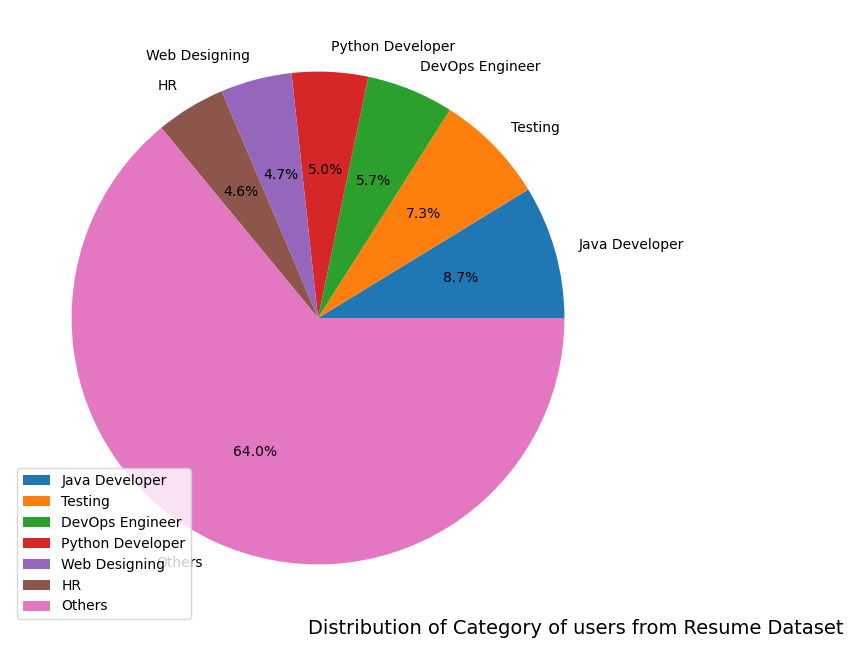

In [3]:
top=6
# count the number of books per company
count_per_company = user_df['Category'].value_counts()

# create a list of top 6 companies and group the rest as "Others"
top_top = count_per_company[:top].index.tolist()
others_count = count_per_company[top:].sum()
top_top.append('Others')
count_per_top_top = count_per_company[:top].tolist()
count_per_top_top.append(others_count)

# plot a pie chart of the book companies distribution
plt.subplots(figsize = (8,8))
plt.pie(count_per_top_top, labels=top_top, autopct='%.1f%%')
plt.legend()
plt.text(0.5, 0.1, 'Distribution of Category of users from Resume Dataset', fontsize=14, transform=plt.gcf().transFigure)
plt.show()

In [4]:
# df=pd.read_csv("/kaggle/input/scrapeddata/cleaned_jobs.csv")
df=pd.read_csv("/kaggle/input/newjobdata/data_analyst.csv").reset_index()
df=df.rename(columns={'index':'Index','Job Description':'Description'})
df=df.set_index('Index')
df.head()

,Position,Company,Location,Description,src
Index,,,,,
0,Data Scientist,Barclays,"Delhi, Delhi, India",About the job\nJob Title: Data Scientist\n\nLo...,https://media.licdn.com/dms/image/C4E0BAQFAXc9...
1,Data Encryption Security Architect,Accenture in India,"Chennai, Tamil Nadu, India",About the job\nAbout Accenture: Accenture is a...,https://media.licdn.com/dms/image/C4D0BAQHu-o4...
2,Sr. Systems Engineer - Oracle PL/SQL (2-3 year...,Infosys,"Jaipur, Rajasthan, India",About the job\nResponsibilities\n A day in the...,https://media.licdn.com/dms/image/C4D0BAQFT17A...
3,Middleware/QNX-Technical Leader,KPIT,"Kochi, Kerala, India",About the job\nJob Description\n\nThe technica...,https://media.licdn.com/dms/image/C4E0BAQFuu9k...
4,Data Scientist,Jumio Corporation,"Jaipur, Rajasthan, India",About the job\nRole Purpose:\n\nThe position i...,https://media.licdn.com/dms/image/C560BAQEsjam...


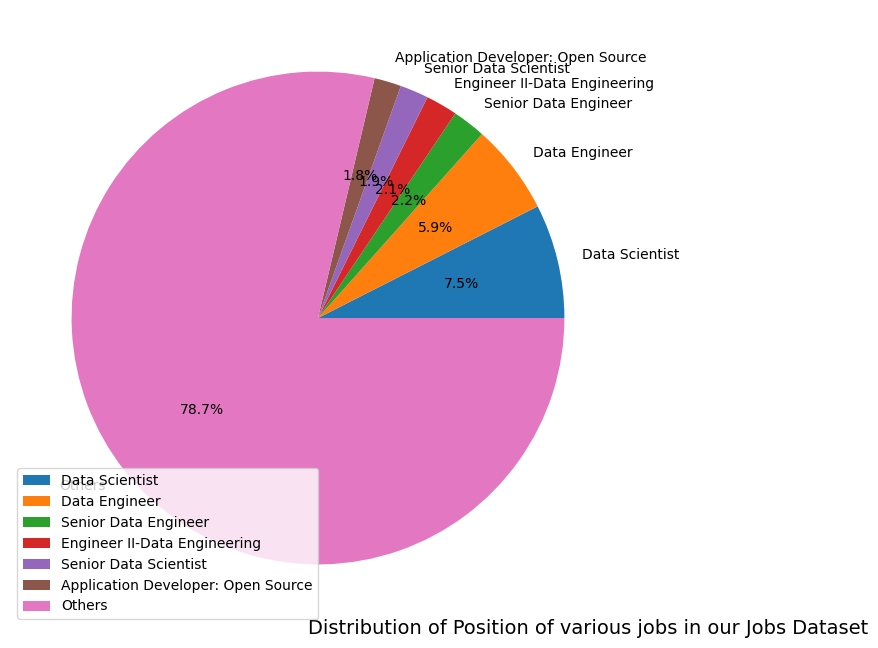

In [5]:
top=6
# count the number of books per company
count_per_company = df['Position'].value_counts()

# create a list of top 6 companies and group the rest as "Others"
top_top = count_per_company[:top].index.tolist()
others_count = count_per_company[top:].sum()
top_top.append('Others')
count_per_top_top = count_per_company[:top].tolist()
count_per_top_top.append(others_count)

# plot a pie chart of the book companies distribution
plt.subplots(figsize = (8,8))
plt.pie(count_per_top_top, labels=top_top, autopct='%.1f%%')
plt.legend()
plt.text(0.5, 0.1, 'Distribution of Position of various jobs in our Jobs Dataset', fontsize=14, transform=plt.gcf().transFigure)
plt.show()

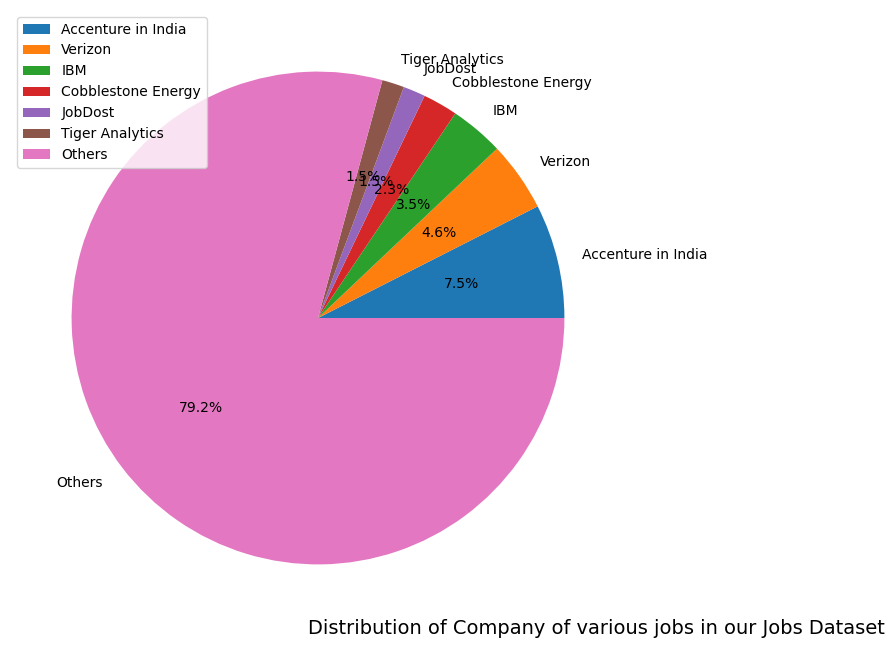

In [6]:
# count the number of books per company
count_per_company = df['Company'].value_counts()

# create a list of top 6 companies and group the rest as "Others"
top_6 = count_per_company[:6].index.tolist()
others_count = count_per_company[6:].sum()
top_6.append('Others')
count_per_top_6 = count_per_company[:6].tolist()
count_per_top_6.append(others_count)

# plot a pie chart of the book companies distribution
plt.subplots(figsize = (8,8))
plt.pie(count_per_top_6, labels=top_6, autopct='%.1f%%')
plt.legend()
plt.text(0.5, 0.1, 'Distribution of Company of various jobs in our Jobs Dataset', fontsize=14, transform=plt.gcf().transFigure)
plt.show()

In [7]:
# import pickle
# # Open the pickle file for reading
# with open('/kaggle/input/embeddings/jobEmbeddingArya.pickle', 'rb') as f:
# #     Use pickle to load the variable from the file
#     job_embeddings = pickle.load(f)

# # Print the loaded variable
# print(job_embeddings.shape)

In [8]:
tokenizer = AutoTokenizer.from_pretrained("MohammedDhiyaEddine/job-skill-sentence-transformer-tsdae")
model = AutoModel.from_pretrained("MohammedDhiyaEddine/job-skill-sentence-transformer-tsdae").to(device)

In [9]:
list_of_lists =[item for sublist in df.values.tolist() for item in sublist]
len(list_of_lists)

4810

In [10]:
list_of_lists =[item for sublist in list_of_lists for item in sublist.split(" ")]
len(list_of_lists)

392839

In [11]:
list_of_lists[0]

'Data'

In [12]:
dict={}

In [13]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
import numpy as np
n=int(df.shape[0])
max_len=512
embeddings=torch.Tensor([]).to(device)#(np.zeros((n,df.shape[1],max_len,768)))
for i in range(n):
    sentences =list_of_lists[i]
    encoded_sentences = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt",max_length=max_len)
    encoded_sentences.to(device)
    with torch.no_grad():
        temp=model(**encoded_sentences)
    sentence_embeddings = mean_pooling(temp, encoded_sentences['attention_mask'])
    embeddings=torch.cat((embeddings,sentence_embeddings),0)
    dict[sentences]=sentence_embeddings

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


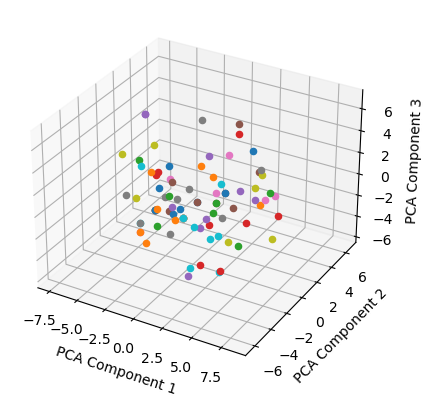

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
import random

# Use PCA to reduce dimensionality of embeddings
pca = PCA(n_components=3)
pca_embeddings = pca.fit_transform(embeddings.cpu())

# Detect and remove outliers using EllipticEnvelope
outlier_detector = EllipticEnvelope(contamination=0.01)
outlier_detector.fit(pca_embeddings)
inliers_mask = outlier_detector.predict(pca_embeddings) == 1
pca_embeddings_inliers = pca_embeddings[inliers_mask]

# Select a random subset of words and their embeddings
random_indices = random.sample(range(len(dict)), 90)
random_words = [list(dict.keys())[i] for i in random_indices]
random_embeddings = pca_embeddings[random_indices]

# Set axis limits based on range of embeddings
x_min, x_max = random_embeddings[:, 0].min(), random_embeddings[:, 0].max()
y_min, y_max = random_embeddings[:, 1].min(), random_embeddings[:, 1].max()
z_min, z_max = random_embeddings[:, 2].min(), random_embeddings[:, 2].max()
x_range = x_max - x_min
y_range = y_max - y_min
z_range = z_max - z_min
x_margin = 0.1 * x_range
y_margin = 0.1 * y_range
z_margin = 0.1 * z_range

# Plot random subset of embeddings in 3D with legend to the right
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i, word in enumerate(random_words):
    ax.scatter(random_embeddings[i, 0], random_embeddings[i, 1], random_embeddings[i, 2], label=word)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_xlim(x_min - x_margin, x_max + x_margin)
ax.set_ylim(y_min - y_margin, y_max + y_margin)
ax.set_zlim(z_min - z_margin, z_max + z_margin)

# ax = Axes3D.add_caption(ax, caption)
# ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# plt.text(0.5, 1, 'Visualization of embe-ddings in 3D(for 50 words)', fontsize=14, transform=plt.gcf().transFigure)
plt.show()